In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

from Config.CustomConfig import CaltechBirdsConfig
from data.CustomDataset import CaltechBirdsDataset
from model.MaskRcnn import MaskRCNN
from Utils import visualize

import tensorflow as tf

D:\ProgramData\Anaconda3\envs\tensorflowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\envs\tensorflowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\envs\tensorflowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramData\Anaconda3\envs\tensorflowGpu\lib\s

In [ ]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# for tensorflow version 1.x
import keras.backend.tensorflow_backend as KTF

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)
KTF.set_session(sess)

['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
# ROOT_DIR = os.path.abspath('.')
ROOT_DIR = 'D:\\coursera\\maskrcnn'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "checkpoint")

ROOT_DIR, MODEL_DIR

('D:\\coursera\\maskrcnn', 'D:\\coursera\\maskrcnn\\checkpoint')

In [4]:
# Training dataset
dataset_train = CaltechBirdsDataset()
dataset_train.load_birds('D:\DataSet\\birds', 'train')
# dataset_train.load_birds(os.path.join(ROOT_DIR, 'dataset/birds'), "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CaltechBirdsDataset()
dataset_val.load_birds('D:\DataSet\\birds', "val")
# dataset_val.load_birds(os.path.join(ROOT_DIR, 'dataset/birds'), "val")
dataset_val.prepare()

55it [00:00, 240.84it/s]
7it [00:00, 219.33it/s]


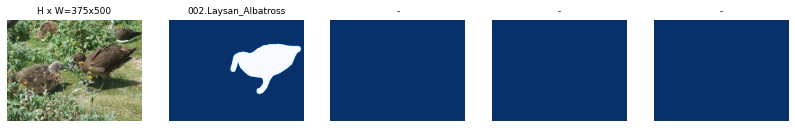

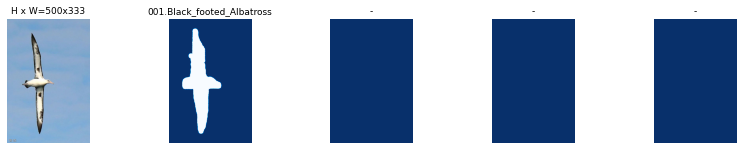

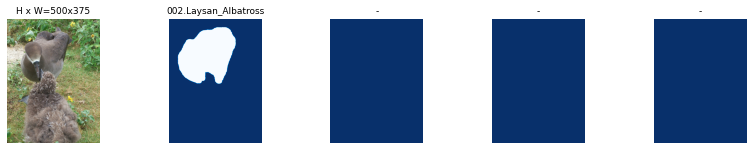

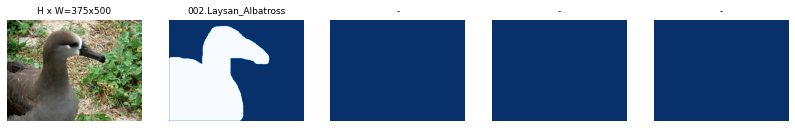

In [5]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [5]:
config = CaltechBirdsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  704
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  704
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [704 704   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [6]:
# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "pretrain\\mask_rcnn_coco.h5")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "pretrain/mask_rcnn_coco.h5")

In [7]:
model = MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
    )
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=3,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\coursera\maskrcnn\checkpoint\bird20200609T2306\mask_rcnn_bird_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mas

D:\ProgramData\Anaconda3\envs\tensorflowGpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/3
50/50 [==============================] - 119s 2s/step - loss: 2.0490 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.7561 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.7974 - mrcnn_mask_loss: 0.3736 - val_loss: 1.1562 - val_rpn_class_loss: 0.0050 - val_rpn_bbox_loss: 0.2696 - val_mrcnn_class_loss: 0.1127 - val_mrcnn_bbox_loss: 0.5805 - val_mrcnn_mask_loss: 0.1884
Epoch 2/3
43/50 [========================>.....] - ETA: 8s - loss: 0.9093 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1902 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.4209 - mrcnn_mask_loss: 0.2057

In [ ]:
model_path = os.path.join(MODEL_DIR, "mask_rcnn_bird.h5")
model.keras_model.save_weights(model_path)

inference

In [3]:
from Utils.sample_utils import color_splash
from data.DataGenerator import load_image_gt
from Utils.utils import log

In [4]:
class InferenceConfig(CaltechBirdsConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

In [5]:
model_path = os.path.join(MODEL_DIR, 'mask_rcnn_bird.h5')
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  D:\coursera\maskrcnn\checkpoint\mask_rcnn_bird.h5


In [20]:
# Validation dataset
dataset_val = CaltechBirdsDataset()
# dataset_val.load_birds('D:\DataSet\\birds', "val")
dataset_val.load_birds('D:\DataSet\\birds', "train")
dataset_val.prepare()

5429it [01:44, 51.97it/s]


original_image           shape: (960, 960, 3)         min:    0.00000  max:  254.00000  uint8
image_meta               shape: (213,)                min:    0.00000  max: 4115.00000  float64
gt_class_id              shape: (1,)                  min:  102.00000  max:  102.00000  int32
gt_bbox                  shape: (1, 4)                min:  274.00000  max:  543.00000  int32
gt_mask                  shape: (960, 960, 1)         min:    0.00000  max:    1.00000  bool


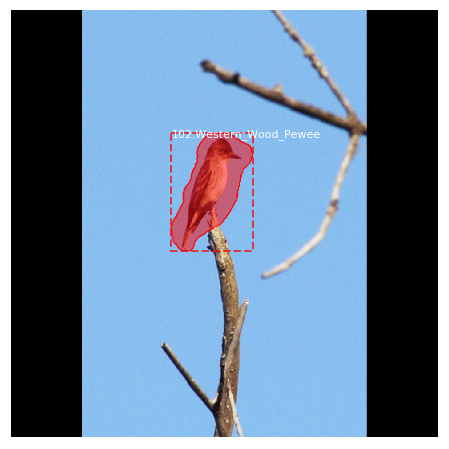

In [25]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_val.class_names, figsize=(8, 8))

In [22]:
results = model.detect([original_image], verbose=1)

r = results[0]

Processing 1 images
image                    shape: (960, 960, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 960, 960, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 213)              min:    0.00000  max:  960.00000  int32
anchors                  shape: (1, 230175, 4)        min:   -0.37752  max:    1.31078  float32


In [26]:
results

[{'rois': array([], shape=(0, 4), dtype=int32),
  'class_ids': array([], dtype=int32),
  'scores': array([], dtype=float32),
  'masks': array([], shape=(960, 960, 0), dtype=float64)}]


*** No instances to display *** 



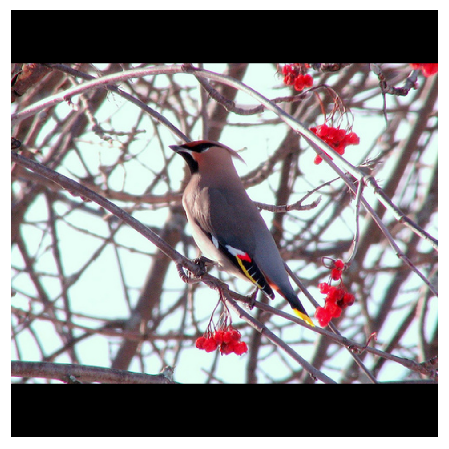

In [24]:
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(8, 8))

In [ ]:
splash = color_splash(original_image, r['masks'])
plt.imshow(splash)

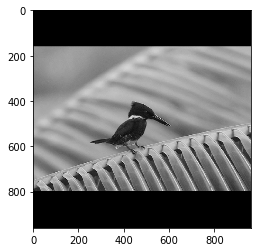